In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
from scipy import stats
# import carbon_utils
# import PyCO2SYS as pyco2
from tabulate import tabulate
from io import StringIO  # for creating a string buffer to store the table
from multiprocessing import Pool
import functions.pressure_level_glodap_mean as pl
from datetime import datetime
import functions.plot_offsets_crossover_plot_only as plot_gdap
import time
import functions.outlier_filter_ESD_test as outlier


### Set up paths

In [4]:
adjustment=False
# glodap_offsets_filename = 'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4.nc'
# glodap_offsets_filename = 'glodap_offsets_100km_2_to_50_50m_0.1dens_0.1spice_5.nc'
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]

if adjustment is True:
    argo_path = argo_path + '../Corrected/Sprof/'

# Set the paths
output_dir = argo_path + '../output_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14/'
# output_dir = argo_path + '../output_100km_400_to_2100_100m_0.005dens_0.005spice_ESPER_14/'

data_dir = 'data/'

# Check for a glodap_offsets_plots directory, create if it does not exist
offset_dir = output_dir + 'glodap_offset_plots/'
if not os.path.isdir(offset_dir):
    os.mkdir(offset_dir)
# if not os.path.isdir(grouped_plot_dir):
#     os.mkdir(grouped_plot_dir)


# inputs that will not normally change
var_list_plot = ['PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED','DOXY_ADJUSTED','NITRATE_ADJUSTED',
                    'DIC','pH_25C_TOTAL_ADJUSTED','PH_IN_SITU_TOTAL_ADJUSTED','PDENS']


### Identify files, pressure levels, float age bins

In [8]:
# user inputs
# calculate trimmed means at different pressure levels for listed files
# grouped_plot_dir = offset_dir + '2024_01_16/'
grouped_plot_dir = offset_dir + '2024_03_21/'

# todays_date = datetime.today().strftime('%Y_%m_%d')
# grouped_plot_dir = offset_dir + 'grouped_plots/' + todays_date + '/'

# grouped_plot_dir = offset_dir + 'grouped_plots/levels_mean_saved/'

if not os.path.isdir(grouped_plot_dir):
    os.mkdir(grouped_plot_dir)

# glodap_offsets_filenames = ['glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005_spice_7.nc']
# glodap_offsets_filenames = ['glodap_offsets_100km_1_to_550_50m_0.05dens_0.05spice_6.nc', 'glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_6.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_550_50m_0.05dens_0.05_spice_7.nc', 'glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005_spice_7.nc']
# glodap_offsets_filenames = ['glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_LIPHR_7.nc']
# glodap_offsets_filenames = ['output_50km_1_to_550_50m_0.05dens_0.05spice_ESPER_14.nc', 'glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_550_50m_0.05dens_0.05spice_ESPER_14.nc','glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']
glodap_offsets_filenames = ['glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']

# pressure_levels = [1500, 2000]  # Adjust as needed
# pressure_levels = [0, 100, 200, 300, 400, 500, 750, 1000, 1250, 1500, 2000]  # Adjust as needed
pressure_levels = [1500, 2000]  # Adjust as needed

# pressure_levels = [1500, 1700, 2000]  # Adjust as needed

year_filt = 0
year_plus_minus = 5

# bin edges in days to calculat mean offset as it evolves over the float/optode's age
float_age_bins = [0, 365/2, 365, 365*2, 365*3, 365*7]
# float_age_bins = [0, 365, 365*7]
# float_age_bins = [0, 365*10]



In [ ]:
print(argo_path + '../output_' + filename[15:-3] + '/')
print(output_dir)

In [ ]:
filename

In [ ]:
os.path.isdir(argo_path + '../' + filename[0:-3] )

### prepare the list of arguments to pass to pressure_level_filter


In [9]:
glodap_offsets = []
delay_between_starts = 5  # number of seconds for each additional instance to wait, may help with a memory bottleneck 

for filename in glodap_offsets_filenames:
        ds = xr.load_dataset(argo_path + '../output_' + filename[15:-3] + '/' +filename)
        # ds = xr.load_dataset(output_dir+filename)
        glodap_offsets.append(ds)

gdap_mean_args = []
for idx, gdap_offsets_n in enumerate(glodap_offsets):
        time_delay = 0
        gdap_offsets_n_temp = gdap_offsets_n.copy()
        for j in range(len(pressure_levels) - 1):
                # only add to the processing list if the pressure level is in the correct range for a given file, otherwise skip 
                if np.logical_and(np.nanmin(gdap_offsets_n_temp.PRES_ADJUSTED_float)<= pressure_levels[j+1], np.nanmax(gdap_offsets_n_temp.PRES_ADJUSTED_float)>= pressure_levels[j]):
                        print(idx)
                        print(pressure_levels[j])
                        time_delay = time_delay+ delay_between_starts
                        gdap_mean_args_n = [(argo_path,grouped_plot_dir,
                                glodap_offsets_filenames[idx][0:-3],
                                gdap_offsets_n_temp, 
                                var_list_plot,year_filt,pressure_levels[j],
                                pressure_levels[j+1],year_plus_minus,time_delay, float_age_bins) ]
                        gdap_mean_args.extend(gdap_mean_args_n)
                # break   
        # break
print(len(gdap_mean_args))

0
1500
1


In [ ]:
##### test cell for pressure_level_glodap_mean

pressure_level_min = pressure_levels[j]
pressure_level_max = pressure_levels[j+1]

time.sleep(time_delay) 
# set all data not at that pressure level to nan                  
for var in var_list_plot:
    pressure_index = np.logical_and(gdap_offsets_n_temp['PRES_ADJUSTED_float']>pressure_level_min, 
                            gdap_offsets_n_temp['PRES_ADJUSTED_float']<=pressure_level_max)

    if year_filt==0:
        gdap_offsets_n_temp[var + '_float'] = gdap_offsets_n_temp[var + '_float'].where(pressure_index)
        gdap_offsets_n_temp[var + '_glodap'] = gdap_offsets_n_temp[var + '_glodap'].where(pressure_index)
        gdap_offsets_n_temp[var + '_offset'] = gdap_offsets_n_temp[var + '_offset'].where(pressure_index)
    elif year_filt==1:
        year_index = np.abs(gdap_offsets_n_temp.main_float_juld.dt.year-gdap_offsets_n_temp.glodap_datetime.dt.year)<=year_plus_minus
        gdap_offsets_n_temp[var + '_float'] = \
            gdap_offsets_n_temp[var + '_float'].where(np.logical_and(pressure_index, year_index))
        gdap_offsets_n_temp[var + '_glodap'] = \
            gdap_offsets_n_temp[var + '_glodap'].where(np.logical_and(pressure_index, year_index))
        gdap_offsets_n_temp[var + '_offset'] = \
            gdap_offsets_n_temp[var + '_offset'].where(np.logical_and(pressure_index, year_index))
        
# then group by wmo and proceed with DOXY_trimmed calculations
offsets_g = gdap_offsets_n_temp.groupby(gdap_offsets_n_temp.main_float_wmo)

if pressure_level_min<=400:
    # adding option to filter by time of year as well - for use in surface data
    time_filt = 1
    filt_days = 10
else:
    time_filt=0


# DOXY_ADJUSTED_offset_trimmed = []
# DOXY_ADJUSTED_offset_trimmed = []
# Create an empty data variable for DOXY offset trimmed with the same dimensions as N_CROSSOVERS
empty_data = np.empty(len(gdap_offsets_n_temp['N_CROSSOVERS']))
empty_data[:] = np.nan


# Create a new xarray DataArray with the empty data and the same coordinates
new_data_array = xr.DataArray(empty_data, coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']}, dims=['N_CROSSOVERS'])
gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed'] = new_data_array

for n,g in offsets_g:

    # run a GESD test using "test_num" number of possible outliers
    test_num = int((len(g.DOXY_ADJUSTED_offset.dropna(dim="N_CROSSOVERS", how="any").values)*.1)) # allowing for ~10 % to be outliers
    ESD_test_out = outlier.ESD_Test(g.DOXY_ADJUSTED_offset.dropna(dim="N_CROSSOVERS", how="any").values, 0.05, test_num, False, True)

    # only trim the data if deep, otherwise apply a day of year test but no other filtering 
    if time_filt==1:
        within_days = np.logical_or(np.abs(g.main_float_juld.dt.dayofyear - g.glodap_datetime.dt.dayofyear)<=filt_days, 
                        np.abs(g.main_float_juld.dt.dayofyear - g.glodap_datetime.dt.dayofyear)>(365-filt_days)) 
        temp_o2_offset = g.DOXY_ADJUSTED_offset.where(within_days)
    else:         # create temp_o2_offest to set all datapoints to nans that the GESD test says are outliers

        temp_o2_offset = g.DOXY_ADJUSTED_offset
        for a in range(0, ESD_test_out[1]):
            temp_o2_offset = temp_o2_offset.where(temp_o2_offset != ESD_test_out[2][a])

    # if there are too few points, set all to nans
    if temp_o2_offset.count()<20:
        temp_o2_offset[:] = np.nan

    # replace nan values with values of temp_o2_offset
    gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed'][gdap_offsets_n_temp['main_float_wmo']==[n]] = temp_o2_offset

    # append each temp_o2_offset to the new DOXY_ADJUSTED_offset_trimmed vector
    # DOXY_ADJUSTED_offset_trimmed.append(temp_o2_offset.values)
    #print(len(DOXY_ADJUSTED_offset_trimmed))
    break

# concatenate all vectors within DOXY_ADJUSTED_offset_trimmed (each represents one WMO)
# result_vector = np.concatenate(DOXY_ADJUSTED_offset_trimmed)
# # convert to Xarray DataArray
# result_da = xr.DataArray(result_vector, dims='N_CROSSOVERS', coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']})
# # add to glodap_offsets
# gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed']=result_da
# print(glodap_offsets)

# calculate mean DOXY_ADJUSTED_offsets for different day ranges
if len(float_age_bins)>0: # 0 = skip and do not apply
    print('in age section')
    # create new variables that will be the mean offsets for different time ranges
    empty_data = np.empty(len(gdap_offsets_n_temp['N_CROSSOVERS']))
    empty_data[:] = np.nan
    new_data_array = xr.DataArray(empty_data, coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']}, dims=['N_CROSSOVERS'])

    gdap_offsets_n_temp['First_Float_Profile_Date'] = new_data_array.copy()  # for storing the first date of first float profile

    for fa in range(len(float_age_bins)-1):
        gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])] = new_data_array.copy()
        gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa]) + '_count'] = new_data_array.copy()

    wmo_list = np.unique(gdap_offsets_n_temp.main_float_wmo)
    # loop through all floats
    for wmo_n in wmo_list:
        print(wmo_n)
        # load Sprof file, get date of first profile
        argo_n = xr.open_dataset(argo_path + str(wmo_n) + '_Sprof.nc')
        first_profile_date = argo_n.JULD[0].values

        gdap_offsets_n_temp['First_Float_Profile_Date'][gdap_offsets_n_temp.main_float_wmo==wmo_n] = first_profile_date

        # calculate offset time relative to first deployment
        time_since_first_ns = gdap_offsets_n_temp.main_float_juld[gdap_offsets_n_temp.main_float_wmo==wmo_n].values-first_profile_date
        time_since_first_days = time_since_first_ns / np.timedelta64(1, 'D')

        # save out o2 offsets for this float
        temp_o2_offset = gdap_offsets_n_temp.DOXY_ADJUSTED_offset[gdap_offsets_n_temp.main_float_wmo==wmo_n]


        # now loop through float_age_bins to calculate mean offsets for each age range 
        for fa in range(len(float_age_bins)-1):
            print(fa)
            # find ages within range
            age_index = np.logical_and(time_since_first_days>=float_age_bins[fa], time_since_first_days<float_age_bins[fa+1])

            # save the mean o2 offset where age_index is true to the correct age variable for that float
            if not np.all(np.isnan(temp_o2_offset.where(age_index).values)):
                gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])]\
                    [gdap_offsets_n_temp.main_float_wmo==wmo_n] = np.nanmean(temp_o2_offset.where(age_index).values)
            gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa]) + '_count']\
                                [gdap_offsets_n_temp.main_float_wmo==wmo_n] = (temp_o2_offset.where(age_index).count())

        break



### run pressure level filter for all files, all pressures 


In [10]:
num_processes = 12 # number of cpus to use 

if __name__ == "__main__":
    
    with Pool(processes=num_processes) as pool:
        # Use pool.starmap with the list of arguments
        pool.starmap(pl.pressure_level_filter, gdap_mean_args)

H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 2
2
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 1
1
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 2
2
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data


### Take netcdf output of crossovers and load all into gdap_offsets and mean_gdap_offsets

In [11]:
# put all .nc files into grouped arrays 


mean_gdap_offsets = {}
gdap_offsets = {}
# glodap_offsets_filenames = ['glodap_offsets_100km_1_to_550_50m_0.05dens_0.05spice_6.nc', 'glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_6.nc']
# pressure_levels = [0, 100, 200, 300, 400, 500, 750, 1000, 1250, 1500, 2000]  # Adjust as needed
# year_filt = 1
# year_plus_minus = 5
# load .nc files saved out for pressure levels
for idx, filename in enumerate(glodap_offsets_filenames):

        trimmed_means = {}
        # variables with offsets that you want to trim

        gdap_offsets_file = {}
        for j in range(len(pressure_levels) - 1):
                pressure_level_min = pressure_levels[j]
                nc_filename_mean = grouped_plot_dir+filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                        'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'
                
                
                try:
                        ds = xr.load_dataset(nc_filename_mean)
                except:
                        continue
                trimmed_means[f'level_{pressure_levels[j]}'] = ds
                
                nc_filename_all = grouped_plot_dir+filename[0:-3]+ '_all_offsets_depth_grouped_' + \
                                        'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'
                all_offsets_ds = xr.load_dataset(nc_filename_all)
                gdap_offsets_file[f'level_{pressure_levels[j]}'] = all_offsets_ds
                # break
        mean_gdap_offsets[glodap_offsets_filenames[idx]]=trimmed_means
        gdap_offsets[glodap_offsets_filenames[idx]]=gdap_offsets_file
        # break


### For comparison to Zack's surface seasonal cycles in glodap

In [104]:
idx = 0

offsets_mean = mean_gdap_offsets[glodap_offsets_filenames[idx]]['level_0']
offsets_all = gdap_offsets[glodap_offsets_filenames[idx]]['level_0']
offsets_mean

# offsets_mean['DOXY_ADJUSTED_offset'][offsets_mean.main_float_wmo=='1900722']



<xarray.Dataset>
Dimensions:                               (main_float_wmo: 860)
Coordinates:
  * main_float_wmo                        (main_float_wmo) object '1900722' ....
Data variables: (12/72)
    p_compare_min                         (main_float_wmo) float64 1.0 ... 1.0
    p_compare_max                         (main_float_wmo) float64 550.0 ... ...
    delta_dens                            (main_float_wmo) float64 0.05 ... 0.05
    delta_spice                           (main_float_wmo) float64 0.05 ... 0.05
    delta_press                           (main_float_wmo) float64 50.0 ... 50.0
    dist                                  (main_float_wmo) float64 50.0 ... 50.0
    ...                                    ...
    pH_sensor                             (main_float_wmo) object 'none' ... ...
    nitrate_group                         (main_float_wmo) object 'no nitrate...
    nitrate_sensor                        (main_float_wmo) object 'none' ... ...
    DOXY_group                            (main_float_wmo) object 'DOXY' ... ...
    DOXY_sensor                           (main_float_wmo) object 'AANDERAA_O...
    ice_group                             (main_float_wmo) object 'no ice' .....

In [109]:
offsets_all.DOXY_ADJUSTED_offset_trimmed[offsets_all.main_float_wmo=='4901141']

<xarray.DataArray 'DOXY_ADJUSTED_offset_trimmed' (N_CROSSOVERS: 268)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
       -66.11931952, -67.19931952, -66.81931952, -64.11931952,
       -65.75931952, -65.75931952, -64.12931952, -61.75931952,
       -60.06068585,          nan,          nan,          nan,
                nan, -64.02931952, -62.93931952, -59.71688215,
                nan,          nan,          nan,          nan,
                nan, -74.71648131, -75.76803016,          nan,
                nan,          nan,          nan, -71.80931952,
       -72.35025625,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
...
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
       -85.77334532, -88.77334532,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
       -68.09968958, -68.19968958,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan])
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 0 1 2 3 4 5 6 ... 262 263 264 265 266 267

In [111]:
offsets_all.glodap_cruise[np.logical_and(offsets_all.main_float_wmo=='4901141', ~np.isnan(offsets_all.DOXY_ADJUSTED_offset_trimmed))]

<xarray.DataArray 'glodap_cruise' (N_CROSSOVERS: 38)>
array([ 171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  171,
        171,  173,  173,  173,  173,  164,  164,  164,  164,  168,  168,
        171,  171,  171,  171,  171,  171,  171,  171,  171,  171,  161,
        161,  165,  165, 1048, 1048])
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 36 37 38 39 40 41 ... 186 196 197 228 229

In [96]:
#read in zack's .csv 
csv_path = "/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Projects/2022_09 Nachod/Projects/Biomes/float_relations/float_biome_stats.csv"
surf_seasonal_offset = pd.read_csv(csv_path)

In [97]:
surf_seasonal_offset["crossover_offset_conc"]=""
surf_seasonal_offset["crossover_offset_conc"]=np.nan

In [98]:
# add my mean offsets to Zack's dataframe:
for n in range(0, offsets_mean.main_float_wmo.shape[0]):
    surf_seas_index = surf_seasonal_offset.wmo==int(offsets_mean.main_float_wmo[n].data)
    surf_seasonal_offset.loc[surf_seas_index, 'crossover_offset_conc']=offsets_mean['DOXY_ADJUSTED_offset_trimmed'][n].values
    

In [99]:
surf_seasonal_offset

,Unnamed: 0,wmo,biome_num,mean_offset_percent_monthly,median_offset_percent_monthly,mean_offset_conc_monthly,median_offset_conc_monthly,mean_offset_percent_weekly,median_offset_percent_weekly,mean_offset_conc_weekly,median_offset_conc_weekly,crossover_offset_conc
0,0,1900722,15,-1.042468,-0.972345,-2.331125,-2.438822,-0.854796,-0.758647,-1.861975,-1.843062,NaN
1,1,1901134,15,-3.235904,-3.064819,-8.195929,-7.823809,-3.002373,-2.781788,-7.611985,-7.195625,NaN
2,2,1901135,15,0.678818,0.707428,1.466126,1.224377,0.857628,0.858157,1.910906,1.366727,12.115544
3,3,1901135,16,-1.256647,-1.250129,-4.236731,-4.166880,-1.330547,-1.432934,-4.465205,-4.975807,12.115544
4,4,1901152,15,-2.747311,-2.429952,-6.575941,-5.629893,-2.528948,-2.391398,-6.038556,-5.454011,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1287,1287,6903591,9,1.148590,1.935513,3.253719,5.734975,1.166536,2.500117,3.076418,7.486817,NaN
1288,1288,6903592,9,0.248346,1.371531,0.264511,4.329632,0.415735,2.349372,0.566677,6.092109,NaN
1289,1289,7900566,9,-0.947290,-1.126059,-2.677406,-2.817361,-1.454333,-0.688027,-4.233965,-1.758626,NaN
1290,1290,7900566,10,0.149718,0.732593,-0.071929,0.986682,-0.022573,0.099412,-0.498990,0.934513,NaN


Text(0, 0.5, 'Crossover comparison')

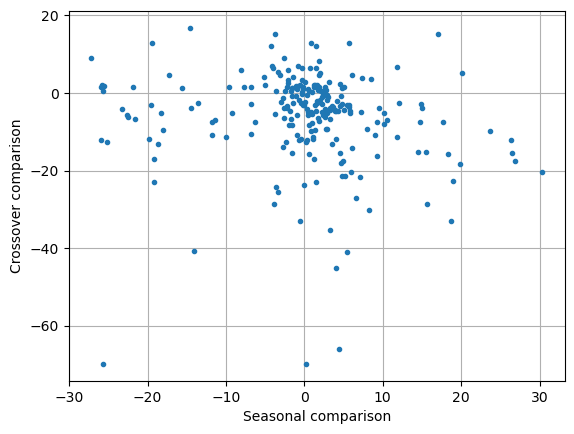

In [100]:
plt.plot(surf_seasonal_offset['mean_offset_conc_monthly'], surf_seasonal_offset['crossover_offset_conc'],'.')
plt.grid('on')
plt.xlabel('Seasonal comparison')
plt.ylabel('Crossover comparison')

In [112]:
surf_seasonal_offset.wmo[np.logical_and(surf_seasonal_offset['mean_offset_conc_monthly']>29, surf_seasonal_offset['crossover_offset_conc']<19)]

320    5901734
Name: wmo, dtype: int64

### Plot individual crossover plots

In [ ]:
# For making individual plots
from importlib import reload

parallel_on = True
reload(plot_gdap)
num_processes = 18 # number of cpus to use 

# make individual glodap crossover plots for each pressure level
# filename = 'glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005_spice_7.nc'
for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):
        pressure_level_min = pressure_levels[j]
        pressure_level_max = pressure_levels[j+1]

        # single_level_offsets = gdap_offsets[filename]['level_1500']
        try:
            single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
            mean_level_offsets = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']

        except:
            continue
        individual_plot_dir = grouped_plot_dir+filename[0:-3]+ '_all_offsets_depth_grouped_' + \
                                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + \
                                                    '_level_' + str(pressure_level_min) + '_individual_floats/'
        if not os.path.isdir(individual_plot_dir):
            os.mkdir(individual_plot_dir)
            
        offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)
        print(individual_plot_dir)
        
        if parallel_on is False:
            if 'checklist' not in locals():
                unique_labels = list(offsets_g.groups.keys())
                checklist = [False] * len(unique_labels)

            print(unique_labels)
        
            for n, g in offsets_g:
                
                index_to_check = unique_labels.index(n)

                # print(checklist[index_to_check])
                if not checklist[index_to_check]:
                    plot_gdap.plot_glodap_crossovers(individual_plot_dir,
                                mean_level_offsets,
                                g, [pressure_level_min, pressure_level_max], float_age_bins)
                    
                    # Find the index of the label in unique_labels
                    index_to_mark_off = unique_labels.index(n)
                    
                    # Mark off the corresponding position in the checklist
                    checklist[index_to_mark_off] = True
                    break
        else:
            if __name__ == "__main__":
                
                with Pool(processes=num_processes) as pool:
                    # Create a list of arguments for pool.starmap
                    gdap_cross_plot_args = [(individual_plot_dir,
                            mean_level_offsets,
                            g, [pressure_level_min, pressure_level_max], float_age_bins) for n, g in offsets_g]
                    print('Here')
                    # Use pool.starmap with the list of arguments
                    pool.starmap(plot_gdap.plot_glodap_crossovers, gdap_cross_plot_args)
        # break



In [ ]:
# create a list to put in True / False if the glodap offsets intersect zero at float mid date

import matplotlib.dates as mdates
import functions.sokal_rohlf_calculations as SR
from scipy import interpolate

CI_alpha = 0.95

for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

        try:
            single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
            # mean_level_offsets = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']

        except:
            continue

        offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)
        glodap_drift_possible_list = []

        for n,g in offsets_g:
            g_ox = g.where(~np.isnan(g.DOXY_ADJUSTED_offset_trimmed), drop=True)
            if g_ox.dims['N_CROSSOVERS']!=0:

                g_ox_sorted = g_ox.sortby("glodap_datetime")
                
                X_series = pd.Series(mdates.date2num(g_ox_sorted.glodap_datetime))
                Y_series = pd.Series(g_ox_sorted.DOXY_ADJUSTED_offset_trimmed.values)

                if len(X_series)<5: # too short to realistically do a regression
                    uncert_min = np.nan
                    uncert_max = np.nan
                else:
                    # Y_series = pd.Series(g_ox_sorted.DOXY_ADJUSTED_offset_trimmed.values)
                    b_yx, a, r2, CI_alpha_slope, ttt, y_err = SR.regress_confidence_sokal_rohlf(X_series, Y_series, CI_alpha)

                    if not np.all(np.isnan(a)):

                        # extrapolate regression and CI if needed to intersect float_mid_date
                        # should apply the slope of the 
                        float_mid_date = mdates.date2num(g.main_float_juld.mean()) # mean float date in number

                        if np.max(X_series)<float_mid_date:
                            X_extend = X_series.append(pd.Series(float_mid_date))
                            y_extend = a+ X_extend*b_yx

                            X_series_last_third = X_series.iloc[np.int64(np.round(len(X_series)*1/2)):-1]
                            Y_err_last_third = y_err.iloc[np.int64(np.round(len(X_series)*1/2)):-1]

                            b_err, a_err, _, _, _, _ = SR.regress_confidence_sokal_rohlf(X_series_last_third, Y_err_last_third, CI_alpha)
                            extrap_error = X_extend.iloc[-1]*b_err+a_err
                            y_err_extend = y_err.append(pd.Series(extrap_error))

                            uncert_min = y_extend.iloc[-1] - y_err_extend.iloc[-1]
                            uncert_max = y_extend.iloc[-1] + y_err_extend.iloc[-1]
                        elif np.min(X_series)>float_mid_date:
                            X_extend = pd.Series(float_mid_date).append(X_series)
                            y_extend = a+ X_extend*b_yx
                            X_series_first_half = X_series.iloc[0:np.int64(np.round(len(X_series)*1/2))]
                            Y_err_first_half = y_err.iloc[1:np.int64(np.round(len(X_series)*1/2))]
                            b_err, a_err, _, _, _, _ = SR.regress_confidence_sokal_rohlf(X_series_last_third, Y_err_last_third, CI_alpha)
                            extrap_error = X_extend.iloc[0]*b_err+a_err
                            y_err_extend = pd.Series(extrap_error).append(y_err)

                #             plt.plot(X_extend, y_extend, color='blue', linestyle = '--')
                #             plt.fill_between(X_extend, y_extend-y_err_extend, y_extend+y_err_extend, color='blue', alpha=0.25)    
                            uncert_min = y_extend.iloc[0] - y_err_extend.iloc[0]
                            uncert_max = y_extend.iloc[0] + y_err_extend.iloc[0]
                        else:
                            y_float = float_mid_date*b_yx+a
                            f = interpolate.interp1d(X_series,y_err)
                            y_float_err = f(float_mid_date)

                            uncert_min = y_float - y_float_err
                            uncert_max = y_float + y_float_err
                    #         print(uncert_min)
                    #         print(uncert_max)

                        
                    if np.isnan(uncert_min):
                        glodap_drift_possible = np.nan
                    elif np.logical_and(uncert_min<0, uncert_max>0):
                        glodap_drift_possible = True
                    else:
                        glodap_drift_possible = False

                    glodap_drift_possible_list.append(glodap_drift_possible)



In [ ]:
# can drift explain offset?
count_true = 0
count_false = 0
for idx, TF in enumerate(glodap_drift_possible_list): 
    if TF is True: 
        count_true= count_true+1
    elif TF is False:
        count_false = count_false+1

print('True ' + str(count_true) + ' or ' + str((count_true/len(glodap_drift_possible_list)*100)))
print('False ' + str(count_false) + ' or ' + str((count_false/len(glodap_drift_possible_list)*100)))


In [ ]:
# are oxygen offsets significantly different from zero?
significant=0
no_offset = 0
for n,g in offsets_g:
    #print("n:", n, "g:", g)
    g_plot = g.DOXY_ADJUSTED_offset_trimmed

    if np.all(np.isnan(g_plot)):
        no_offset = no_offset+1
        continue 
    g_mean = np.nanmean(g_plot.values)
    t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, nan_policy='omit') ############
    
    if  p_value<.05:
        significant = significant+1

print("number significant", significant)
print('number where no offset could be calculated: ' + str(no_offset))
print('Total offsets: ' + str(len(offsets_g)))

In [ ]:
for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

        try:
            single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
            # mean_level_offsets = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']

        except:
            continue

        offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)
        


In [ ]:
single_level_offsets['p_compare_min'][0].item()

In [ ]:
# Depth dependency of offsets:
# 1. Bin by depth - 50m bins? 100m bins?
# 2. Save a dataframe with wmo, depth, o2 conc, o2 offset, o2 offset minus mean o2 offset
# That should give you what you need to plot all float offsets vs. depth and concentration
press_bin_width = 10
press_bins = np.linspace(np.int32(single_level_offsets['p_compare_min'][0].item()), 
                   np.int32(single_level_offsets['p_compare_max'][0].item()), press_bin_width)

press_response_all_df = pd.DataFrame(columns=['wmo','avg_depth','o2_conc', 'o2_offset', 'o2_offset_minus_mean'])
num_count = 0
for n,g in offsets_g:
    num_count = num_count+1    
    print(str(n)+ ' ' + str(num_count))
    g_ox = g.where(~np.isnan(g.DOXY_ADJUSTED_offset_trimmed), drop=True)

    # loop through press_bins, finding pressures that fit and averaging everything
    press_response_data = []  # List to store data

    for idx in range(0, len(press_bins)-1):
        depth_index = np.logical_and(g_ox['PRES_ADJUSTED_float']>=press_bins[idx], 
                                     g_ox['PRES_ADJUSTED_float']<press_bins[idx+1])
        if sum(depth_index)==0:
            continue

        # make a new dataframe for this pressure bin

        press_response_data.append({
                    'wmo': np.int32(g_ox['main_float_wmo'][0].item()),
                    'avg_depth': np.mean(g_ox['PRES_ADJUSTED_float'][depth_index]).values.tolist(),
                    'o2_conc': np.mean(g_ox['DOXY_ADJUSTED_float'][depth_index]).values.tolist(),
                    'o2_offset': np.mean(g_ox['DOXY_ADJUSTED_offset_trimmed'][depth_index]).values.tolist(),
                    'o2_offset_minus_mean': (np.mean(g_ox['DOXY_ADJUSTED_offset_trimmed'][depth_index]).values - \
                                             np.mean(g_ox['DOXY_ADJUSTED_offset_trimmed']).values).tolist()

            })
    # Convert the list of dictionaries into a DataFrame
    press_response_df = pd.DataFrame(press_response_data)
    # concatenate dataframes
    press_response_all_df = pd.concat([press_response_all_df, press_response_df], ignore_index=True)


In [ ]:
press_response_all_df

In [ ]:


# +
plt.subplot(1,2,1)
plt.plot(press_response_all_df['o2_offset_minus_mean'], press_response_all_df['avg_depth'], 'x')
plt.xlim([-20, 20])
plt.grid()
plt.ylim([2050, 1450])

plt.subplot(1,2,2)
plt.plot(press_response_all_df['o2_offset_minus_mean'], press_response_all_df['o2_conc'], 'x')
plt.xlim([-5, 5])
plt.grid()
# plt.ylim([2050, 1450])

In [ ]:
print(hist.statistic.shape)
print(offset_bins[0:-1].shape)
print(o2_bins[0:-1].shape)
print(offset_mesh.T.shape)
print(o2_mesh.T.shape)

In [ ]:
o2_bins = np.arange(0, 350, 5)
offset_bins = np.arange(-10, 10, 0.5)
hist = stats.binned_statistic_2d(press_response_all_df['o2_offset_minus_mean'], press_response_all_df['o2_conc'], None, bins=[offset_bins, o2_bins], statistic="count")

hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
hist.statistic


offset_mesh, o2_mesh = np.meshgrid(offset_bins, o2_bins)



image = plt.pcolormesh(offset_mesh.T, o2_mesh.T, hist.statistic, shading="flat")

# Add colorbar and labels if needed
plt.colorbar(label="Count")
plt.xlabel("Offset")
plt.ylabel("Oxygen Concentration")
plt.grid()
plt.clim(0,50)

In [ ]:
if np.all(np.isnan(g_plot)):
    no_offset = no_offset+1

In [ ]:
single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)


In [ ]:
j=0
pressure_level_min = pressure_levels[j]
nc_filename_mean = filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

nc_filename_mean
glodap_offsets_mean = xr.load_dataset(grouped_plot_dir + nc_filename_mean)


In [ ]:
temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']/glodap_offsets_mean['DOXY_ADJUSTED_glodap']*100
temp_var.mean()

In [ ]:
# Plotting histograms 
year_filt = 0
x_val = 0 # offset in umol / kg
# x_val = 1 # offset in % 

for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

        pressure_level_min = pressure_levels[j]
        nc_filename_mean = filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

        # nc_filename_all = filename[0:-3]+ '_all_offsets_depth_grouped_' + \
        #                         'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

        # if ~os.path.exists(grouped_plot_dir + nc_filename_mean):
        #     continue
        # load files and fix longitude
        # histogram plot for each file / pressure level
        if 'glodap_offsets_mean' in locals():
                del glodap_offsets_mean
        try:
                glodap_offsets_mean = xr.load_dataset(grouped_plot_dir + nc_filename_mean)
        except:
                continue
        
                # don't need to fix longitude in this section of code
        # float_wmo_list = glodap_offsets_p.index.values
        # float_wmo_list = glodap_offsets_mean.main_float_wmo.values
        # if 'glodap_offsets' in locals():
        #     del glodap_offsets


        # glodap_offsets = xr.load_dataset(grouped_plot_dir + nc_filename_all)

        # # loop through mean array
        # for n in range(0,float_wmo_list.shape[0]):
        #         wmo_n = float_wmo_list[n]

        #         # fix long_n mean biases:
        #         temp_LONGITUDE = glodap_offsets.main_float_longitude.where(glodap_offsets.main_float_wmo==wmo_n, drop=True)

        #         if (np.max(temp_LONGITUDE) - np.min(temp_LONGITUDE))>300:
        #                 # print(n)
        #                 new_mean = np.mean(xr.where(temp_LONGITUDE>=0, temp_LONGITUDE, temp_LONGITUDE+360))
        #                 if new_mean>180:
        #                         new_mean = new_mean-360
                                
        #                 old_mean = np.mean(glodap_offsets.main_float_longitude.where(glodap_offsets.main_float_wmo==wmo_n, drop=True))
        #                 # print('old mean: '  + str(old_mean.values))
        #                 # print('orig mean glodap:' + str(glodap_offsets_mean['main_float_longitude'].loc[{'main_float_wmo': wmo_n}].values))

        #                 # print('new mean: '  + str(new_mean.values))

        #                 # put new LONGITUDE into long_n
        #                 glodap_offsets_mean['main_float_longitude'].loc[{'main_float_wmo': wmo_n}] = new_mean.values
        #                 # print('New mean glodap:' + str(glodap_offsets_mean['main_float_longitude'].loc[{'main_float_wmo': wmo_n}].values))

        glodap_offsets_p = glodap_offsets_mean.to_dataframe()


        parameter_a = 'o2_calib_air_group'
        parameter_b = 'pH_group'
        offsets_g = glodap_offsets_p.groupby(parameter_a)
        offsets_pH = glodap_offsets_p.groupby([parameter_a, parameter_b])
        CI_level = 0.95
        plt.rcParams.update({'font.size': 12})

        plt.figure(figsize=(12,12))

        #All Float Crossovers
        plt.subplot(2,2,1)
        if x_val==0:
                temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']
                x_label = r'DOXY Offset ($\mu$mol kg$^{-1}$)'
        elif x_val==1:
                temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']/glodap_offsets_mean['DOXY_ADJUSTED_glodap']*100
                x_label = 'DOXY Offset (%)'

        ncount = temp_var.count()
        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(alpha=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)

        o2_offset_data_table = [('All', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax)]
        plt.hist(temp_var, 
                bins=np.linspace(-65, 65, 61), label='n: '+str(ncount.values) +  '\nmean: ' + str(nmean.values) + '$\pm$' + str(nstd.values) + '\nmed: ' + str(nmedian.values) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}'
                ) # ,label=str(n)
        #print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].median().values, decimals=1))
        plt.grid()
        plt.title('All float crossovers')
        plt.xlabel(x_label)
        plt.ylabel('Count')
        plt.axvline(x=0, color='k')
        plt.legend()

        # All float crossovers, zoomed in
        plt.subplot(2,2,2)
        plt.title('All floats, $\pm$ 20 $\mu$mol kg$^{-1}$ range')

        plt.hist(temp_var, 
                bins=np.linspace(-20, 20, 50),label='median='+str(nmedian.values) + 
                ', n='+str(ncount.values)) # ,label=str(n)
        plt.grid()
        plt.ylabel('Count')
        plt.axvline(x=0, color='k')

        plt.xlabel(x_label)

        # Split into calibration group
        plt.subplot(2,2,3)
        No_air_cal_all = offsets_g.get_group('no air cal')
        if x_val==0:
                temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']/No_air_cal_all['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count() # only counts non-nan values
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(alpha=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('No air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))


        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='No air cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')



        air_cal_all = offsets_g.get_group('air cal')
        if x_val==0:
                temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']/air_cal_all['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count() # only counts non-nan values
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(alpha=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)

        o2_offset_data_table.append(('Air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))


        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='Air cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')


        no_cal_all = offsets_g.get_group('no cal/bad')
        if x_val==0:
                temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']/no_cal_all['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count() # only counts non-nan values
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(alpha=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('No cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='Bad or no cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}')



        #for n, group in offsets_g:
        #    print(n)
        #    nmean = np.around(group['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
        #    nmedian = np.around(group['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
        #    ncount = group['DOXY_ADJUSTED_offset_trimmed'].count()

            

        plt.title('Grouped by calibration approach')

        plt.axvline(x=0, color='k')
        plt.grid()
        plt.xlabel(x_label)
        plt.ylabel('Count')

        plt.legend()

        # pH equipped floats only 
        plt.subplot(2,2,4)
        plt.title('pH equipped floats only')

        no_air_cal_ph = offsets_pH.get_group(('no air cal', 'pH'))
        if x_val==0:
                temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']/no_air_cal_ph['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        ncount = temp_var.count()

        # temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(alpha=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('pH - No cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='No air cal. \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')

        air_cal_ph = offsets_pH.get_group(('air cal', 'pH'))
        if x_val==0:
                temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']/air_cal_ph['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count()
        nstd = np.around(temp_var.std(), decimals=1)
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(alpha=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('pH - Air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.4,label='Air cal. \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}')


        #for n, group in offsets_pH:
        #    if n[1] == 'no pH' or n[0] == 'no cal/bad':
        #        continue
        #    print(n)
        #    nmean = np.around(group['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
        #    nmedian = np.around(group['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
        #    ncount = group['DOXY_ADJUSTED_offset_trimmed'].count()

        plt.xlabel(x_label)
        plt.ylabel('Count')
        plt.axvline(x=0, color='k')

        plt.legend()
            
        plt.tight_layout()
        plt.grid()

        if x_val==0:
                plot_filename = nc_filename_mean
        elif x_val==1:
                plot_filename = nc_filename_mean + '_offset_percent'

        plt.savefig(grouped_plot_dir + plot_filename + '_histogram.png', dpi=300)

        print(tabulate(o2_offset_data_table, headers=['count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))
        

In [ ]:
## plot nitrate, pH, DIC offsets for each file / grouping 
CI_level = 0.95
var_plot = ['NITRATE_ADJUSTED','pH_25C_TOTAL_ADJUSTED', 'DIC']

# Plotting histograms 
year_filt = 0
x_val = 0 # offset in umol / kg

for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

                pressure_level_min = pressure_levels[j]
                nc_filename_mean = filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

                if 'glodap_offsets_mean' in locals():
                    del glodap_offsets_mean
                try:
                        glodap_offsets_mean = xr.load_dataset(grouped_plot_dir + nc_filename_mean)
                except:
                        continue
                
                # plt.rcParams.update({'font.size': 12})
                o2_offset_data_table = []
               
                plt.figure(figsize=(12,5))

                for v, var in enumerate(var_plot):
                    if np.logical_or(var=='PH_IN_SITU_TOTAL_ADJUSTED', var=='pH_25C_TOTAL_ADJUSTED'):
                        scale = 1000
                        x_label_units = '(mpH)'
                    else:
                        scale = 1
                        x_label_units = '($\mu$mol kg$^{-1}$)'
                    #All Float Crossovers
                    plt.subplot(1,3,v+1)
                    ncount = glodap_offsets_mean[var_plot[v] + '_offset'].count().values
                    nmean = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].mean().values*scale, decimals=1)
                    nstd = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].std().values*scale, decimals=1)
                    nmedian = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].median().values*scale, decimals=1)
                    nmin = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].min().values*scale, decimals=1)
                    nmax = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].max().values*scale, decimals=1)

                    temp_var = glodap_offsets_mean[var_plot[v] + '_offset']*scale
                    t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

                    CI_vals = stats.norm.interval(alpha=CI_level, 
                                    loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                                    scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
                    CI_low = np.around(CI_vals[0], decimals=2)
                    CI_high = np.around(CI_vals[1], decimals=2)
                    o2_offset_data_table.append([var_plot[v], 
                                                ncount, 
                                                nmean, 
                                                nstd, 
                                                p_value, CI_low, CI_high, nmedian, nmin, nmax])
                    plt.hist(glodap_offsets_mean[var_plot[v] + '_offset']*scale, 
                            label='n: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + 
                        '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}',bins=25) # ,label=str(n) #bins=np.linspace(-65, 65, 61),
                    #print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].median().values, decimals=1))
                    plt.grid()
                    plt.title('All float crossovers')
                    plt.xlabel(var_plot[v] + ' Offset ' + x_label_units)
                    plt.ylabel('Count')
                    plt.axvline(x=0, color='k')
                    plt.legend(fontsize=9)
                plt.tight_layout

                plot_filename = nc_filename_mean

                plt.savefig(grouped_plot_dir + plot_filename + '_no3_pH_dic_histogram.png', dpi=300)

                print(tabulate(o2_offset_data_table, headers=['count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))


In [ ]:
mean_gdap_offsets

### Setting group names for projects, sensor types, data centers, etc.

In [ ]:
# Assuming 'project_name' is the variable in your xarray dataset
dataset_n = mean_gdap_offsets[filename]['level_1500']
project_name_values = dataset_n['project_name'].values
big_projects = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(project_name_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=10:
        big_projects.append(group_name)

print(big_projects)

In [ ]:
dataset_n = mean_gdap_offsets[filename]['level_1500']
data_center_values = dataset_n['data_centre'].values
data_centers = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(data_center_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=5:
        data_centers.append(group_name)

print(data_centers)

In [ ]:
dataset_n = mean_gdap_offsets[filename]['level_1500']
o2_sensor_values = dataset_n['DOXY_sensor'].values
o2_sensors = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(o2_sensor_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=1:
        o2_sensors.append(group_name)

print(o2_sensors)

In [ ]:
np.mean([float_age_bins[fa], float_age_bins[fa+1]])

In [ ]:
# # want to loop through and save out all pressure values for each type (cal_group) so that I can make some synthesis plots

# cal_groups_all  = [['All', 'air cal', 'no air cal'], o2_sensors, big_projects, data_centers]
# parameter_a_all= ['o2_calib_air_group', 'DOXY_sensor', 'project_name', 'data_centre']

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups = data_centers
# parameter_a = 'data_centre'
cal_groups = ['All', 'air cal', 'no air cal']
parameter_a = 'o2_calib_air_group'

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups  = o2_sensors
# parameter_a= 'DOXY_sensor'

# cal_groups = data_centers
# parameter_a = 'data_centre'

CI_level = 0.95

float_age_filter = 1
# for n, cal_groups in enumerate(cal_groups_all):
#     parameter_a = parameter_a_all[n]

for fa in range(len(float_age_bins)-1):
    o2_offset_data_table = []

    fig = plt.figure(figsize=(27,len(cal_groups)*4))

    for filename in glodap_offsets_filenames:
        
        for j in range(len(pressure_levels)-1):
            try:
                dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
            except:
                continue    
            for idx, cal in enumerate(cal_groups):
                dataset_p = dataset_n.to_dataframe()
                offsets_o2_cal_group = dataset_p.groupby(parameter_a)
                # offsets_pH = dataset_p.groupby([parameter_a, parameter_b])

                if float_age_filter==0:
                    var = 'DOXY_ADJUSTED_offset_trimmed'
                else:
                    var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])
                    age_title = str(float_age_bins[fa]) + ' to ' + str(float_age_bins[fa+1]) + 'days '

                if np.logical_and(idx==0, parameter_a=='o2_calib_air_group'):
                    # print(idx)
                    # print(cal)
                    data_p = dataset_n[var].copy()
                    pressure_p = dataset_n.PRES_ADJUSTED_float

                    if float_age_filter==1:
                        # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                        count_p = dataset_n[var + '_count']
                        data_p[count_p < 20] = np.nan

                else:
                    temp_dataset = offsets_o2_cal_group.get_group(cal)
                    data_p = temp_dataset[var].copy()
                    pressure_p = temp_dataset.PRES_ADJUSTED_float

                    if float_age_filter==1:
                        # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                        count_p = temp_dataset[var + '_count']
                        data_p[count_p < 20] = np.nan

            

                nmean = np.around(data_p.mean(), decimals=1)
                ncount = np.around(data_p.count(), decimals=1)
                nstd = np.around(data_p.std(), decimals=1)
                nmedian = np.around(data_p.median(), decimals=1)
            
                temp_var = data_p.copy()
                t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

                CI_vals = stats.norm.interval(confidence=CI_level, 
                                loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                                scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
                CI_low = np.around(CI_vals[0], decimals=1)
                CI_high = np.around(CI_vals[1], decimals=1)
                ax1 = plt.subplot(len(cal_groups),3,(1+3*idx))
                if float_age_filter==0:
                    plt.title(cal.strip() )
                else:
                    plt.title(cal.strip() + ' ' + age_title)
                plt.plot(data_p, pressure_p,'.')
                plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                plt.grid('on')
                ax2 = plt.subplot(len(cal_groups),3,(2+3*idx))
                plt.title('+/- 20 umol/kg')
                plt.plot(data_p, pressure_p,'.')
                plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                npres = np.around(pressure_p.mean(), decimals=1)
                plt.xlim([-20, 20])
                plt.grid('on')
                o2_offset_data_table.append((idx, npres, ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian))


    for idx, cal in enumerate(cal_groups):
        plt.subplot(len(cal_groups),3,(1+3*idx))
        plt.gca().invert_yaxis()
        plt.plot([0,0], [0, 2000], 'k-')
        plt.subplot(len(cal_groups),3,(2+3*idx))
        plt.gca().invert_yaxis()
        plt.plot([0,0], [0, 2000], 'k-')


    o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
    sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

    # base_value = 1
    # increment = 3
    # num_iterations = 10  

    # for idx in range(num_iterations):
    #     current_value = base_value + increment * idx
    #     print(f"Index: {idx}, Value: {current_value}")

    for idx, cal in enumerate(cal_groups):
        filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
        # Create a string buffer to store the table
        table_buffer = StringIO()

        # Convert the o2_offset_data_table to a table and write it to the buffer
        print(tabulate(filtered_data_table, 
                    headers=['Cal group', 'Pressure', 'count',
                                'mean', 'std', 'p_value', 
                                str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 
                                'median'], tablefmt='grid'), file=table_buffer)

        # Display the table in a subplot
        plt.subplot(len(cal_groups),3,(3+3*idx))
        plt.title(cal.strip())

        plt.axis('off')  # Turn off axis for the table
        # plt.text(0.01, 0.01, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
        plt.text(0.01, 0.95, table_buffer.getvalue(), va='top', ha='left', transform=plt.gca().transAxes, fontfamily='monospace', fontsize=8)
        
        # break

    plot_filename = var + '_vs_depth_grouped_' + parameter_a + '_year_filt_' + str(year_filt) +'_' + str(year_plus_minus) 
    plt.savefig(grouped_plot_dir + plot_filename + '.png', dpi=300)

    o2_offset_table_cal_groups = pd.DataFrame(columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count'])
    
    for idx, cal in enumerate(cal_groups):
        filtered_data_table = [row for row in sorted_data_table if row[0] == idx]

        for i in range(0,len(filtered_data_table)):
            new_data_o2_direct_impact = [(cal.strip(), 
                                        filtered_data_table[i][1], 
                                        filtered_data_table[i][3],
                                        filtered_data_table[i][6],
                                        filtered_data_table[i][7],
                                        filtered_data_table[i][2])]
            new_data_o2_direct_impact_df = pd.DataFrame(new_data_o2_direct_impact, columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count'])
            o2_offset_table_cal_groups = pd.concat([o2_offset_table_cal_groups, new_data_o2_direct_impact_df], ignore_index=True)

    if parameter_a=='project_name':
        n_cutoff= 10
        x_lim = [-25, 10]
    elif parameter_a=='DOXY_sensor':
        n_cutoff = 5
        x_lim = [-15, 5]
    elif parameter_a == 'o2_calib_air_group':
        n_cutoff = 0
        x_lim = [-10, 2.5]
    elif parameter_a == 'data_centre':
        n_cutoff = 5
        x_lim = [-22, 5]


    fig = plt.figure(figsize=(8,8))

    for cal in cal_groups:
        temp_group = o2_offset_table_cal_groups[o2_offset_table_cal_groups['Cal group']==cal.strip()]

        if temp_group.n_count.values.mean()<n_cutoff:
            continue

        line, = plt.plot(temp_group.offset, temp_group.pressure, label=cal.strip() + ' (' + str(temp_group.n_count.values.mean()) + ')')
        
        line_color = line.get_color()
        for i in range(0,len(temp_group)):
            plt.errorbar(temp_group.offset.values[i], temp_group.pressure.values[i], xerr=temp_group.offset.values[i]-temp_group.CI_low.values[i],
                        fmt='o', capsize=5, color=line_color)

    plt.gca().invert_yaxis()
    plt.plot([0,0], [0, 2000], 'k-')
    plt.grid('on')
    plt.xlim(x_lim)
    plt.legend()
    if float_age_filter==0:
        plt.title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt))

    else:
        plt.title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt) + ' ' + age_title)
    plt.xlabel('umol/kg')
    plt.ylabel('Pressure')
    plot_filename = var + 'Offsets_vs_depth_grouped_' + parameter_a + '_year_filt' + str(year_filt) +'_' + str(year_plus_minus) + '_all_cutoff_' + str(n_cutoff) 
    plt.savefig(grouped_plot_dir  + plot_filename + '.png', dpi=600)

    
    if float_age_filter==0:
        break




In [ ]:
# plots of means, SDs, and medians for various groupings 
cal_groups_all  = [o2_sensors, big_projects, data_centers]
parameter_a_all= ['DOXY_sensor', 'project_name', 'data_centre']

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups = data_centers
# parameter_a = 'data_centre'
for n, cal_groups in enumerate(cal_groups_all):
    parameter_a = parameter_a_all[n]
    cal_group_labels = []
    for fa in range(len(float_age_bins)-1):
        o2_offset_data_table = []
        means = []
        stds = []
        medians = []
        counts = []

        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(1,1,1)
        for filename in glodap_offsets_filenames:
            
            for j in range(len(pressure_levels)-1):
                try:
                    dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
                except:
                    continue    
                for idx, cal in enumerate(cal_groups):
                    dataset_p = dataset_n.to_dataframe()
                    offsets_o2_cal_group = dataset_p.groupby(parameter_a)
                    if float_age_filter==0:
                        var = 'DOXY_ADJUSTED_offset_trimmed'
                    else:
                        var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])

                    if np.logical_and(idx==0, parameter_a=='o2_calib_air_group'):
                        # print(idx)
                        # print(cal)
                        data_p = dataset_n[var].copy()
                        pressure_p = dataset_n.PRES_ADJUSTED_float

                        if float_age_filter==1:
                            # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                            count_p = dataset_n[var + '_count']
                            data_p[count_p < 20] = np.nan
                    else:
                        temp_dataset = offsets_o2_cal_group.get_group(cal)
                        data_p = temp_dataset[var].copy()
                        pressure_p = temp_dataset.PRES_ADJUSTED_float

                        if float_age_filter==1:
                            # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                            count_p = temp_dataset[var + '_count']
                            data_p[count_p < 20] = np.nan
                        print(cal)
                    # nmean = np.around(data_p.mean(), decimals=1)
                    # ncount = np.around(data_p.count(), decimals=1)
                    # nstd = np.around(data_p.std(), decimals=1)
                    # nmedian = np.around(data_p.median(), decimals=1)
                    cal_group_labels.append(cal.strip() + ' (' + str(data_p.count())+ ')')

                    means.append(data_p.mean())
                    stds.append(data_p.std())
                    counts.append(data_p.count())
                    medians.append(data_p.median())

        x = np.arange(len(cal_group_labels))

        plt.hlines(0, xmin=0, xmax=len(cal_group_labels)-1, colors='k')
        plt.grid('on')
        # plt.plot(x, means, 's', label='mean')
        plt.errorbar(x, means, yerr=stds, marker='s', label='mean $\pm$ 1 SD', capsize=4)
        plt.plot(x, medians, 'x', label='median', zorder=4, linewidth=4)

        ax.set_xticks(x, labels=cal_group_labels, rotation=45, ha='right')
        # ax.set_xticklabels(cal_group_labels, rotation=45, ha='right')
        ax.set_title(parameter_a)
        ax.legend()
        plt.tight_layout()
        plot_filename = var + '_means_' + parameter_a + '_year_filt_' + str(year_filt) +'_' + str(year_plus_minus)

        plt.savefig(grouped_plot_dir + plot_filename + '.png')
    
            
        

In [ ]:

o2_offset_table_cal_groups = pd.DataFrame(columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count'])
for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]

    for i in range(0,len(filtered_data_table)):
        new_data_o2_direct_impact = [(cal.strip(), 
                                      filtered_data_table[i][1], 
                                      filtered_data_table[i][3],
                                      filtered_data_table[i][6],
                                      filtered_data_table[i][7],
                                      filtered_data_table[i][2])]
        new_data_o2_direct_impact_df = pd.DataFrame(new_data_o2_direct_impact, columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count'])
        o2_offset_table_cal_groups = pd.concat([o2_offset_table_cal_groups, new_data_o2_direct_impact_df], ignore_index=True)

if parameter_a=='project_name':
    n_cutoff= 30
    x_lim = [-25, 10]
elif parameter_a=='DOXY_sensor':
    n_cutoff = 20
    x_lim = [-15, 5]
elif parameter_a == 'o2_calib_air_group':
    n_cutoff = 0
    x_lim = [-10, 2.5]
elif parameter_a == 'data_centre':
    n_cutoff = 30
    x_lim = [-22, 5]


fig = plt.figure(figsize=(8,8))

for cal in cal_groups:
    temp_group = o2_offset_table_cal_groups[o2_offset_table_cal_groups['Cal group']==cal.strip()]

    if temp_group.n_count.values.mean()<n_cutoff:
        continue

    line, = plt.plot(temp_group.offset, temp_group.pressure, label=cal.strip())
    
    line_color = line.get_color()
    for i in range(0,len(temp_group)):
        plt.errorbar(temp_group.offset.values[i], temp_group.pressure.values[i], xerr=temp_group.offset.values[i]-temp_group.CI_low.values[i],
                      fmt='o', capsize=5, color=line_color)

plt.gca().invert_yaxis()
plt.plot([0,0], [0, 2000], 'k-')
plt.grid('on')
plt.xlim(x_lim)
plt.legend()
plt.title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt))
plt.xlabel('umol/kg')
plt.ylabel('Pressure')
plot_filename = 'Offsets_vs_depth_grouped_' + parameter_a + '_year_filt' + str(year_filt) +'_' + str(year_plus_minus) + '_all_cutoff_' + str(n_cutoff)
plt.savefig(grouped_plot_dir  + plot_filename + '.png')

In [ ]:
gdap_offsets[filename]['level_1500'].main_float_wmo=='5903615'

In [ ]:
filtered_data_table

In [ ]:
# Filter out rows with nan values in the first element
o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

# base_value = 1
# increment = 3
# num_iterations = 10  # You can adjust this based on the number of iterations you need

# for idx in range(num_iterations):
#     current_value = base_value + increment * idx
#     print(f"Index: {idx}, Value: {current_value}")

for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
    # print(cal)
    # print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))
    # Create a string buffer to store the table
    table_buffer = StringIO()

    # Convert the o2_offset_data_table to a table and write it to the buffer
    print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median'], tablefmt='grid'), file=table_buffer)

    # Display the table in a subplot
    plt.subplot(len(cal_groups),3,(1+3*idx))
    plt.axis('off')  # Turn off axis for the table
    plt.text(0.1, 0.1, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
    # break

In [ ]:
mean_gdap_offsets[filename]['level_0']

In [ ]:
print(big_projects)

In [ ]:
grouped_data = dataset_n.groupby('project_name')

# Get the group names and the counts of data within each group
group_names = grouped_data.groups.keys()
# group_counts = grouped_data.size()

# Display the group names and counts
for group_name, count in zip(group_names, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")

In [ ]:
for cal_group, group_data in o2_offset_data_table.groupby('Cal group'):
    sorted_data = group_data.sort_values(by='Cal group')  # Sort by 'Cal group' column
    print(tabulate(sorted_data, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))



In [ ]:
o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]

print(o2_offset_data_table)


In [ ]:
# Filter out rows with nan values in the first element
o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
    print(cal)
    print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))



In [ ]:
row

In [ ]:
# now for one dataset you have glodap_offsets_mean saved for each pressure level - need to do for all datasets 
trimmed_means['level_200']